In [1]:
import numpy as np
import scipy
from scipy.linalg import sqrtm
import scipy.sparse as sp
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import torch
from IPython.display import clear_output

from lanczos import lanczos_algorithm
from pygcn.pygcn.utils import load_data, encode_onehot, normalize

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)

# Quora citation dataset

## Data processing

In [2]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(path = 'pygcn/data/cora/')
A = csr_matrix(adj.detach().to_dense().numpy())

Loading cora dataset...


In [3]:
np.squeeze(np.array(A.sum(0)))[:15]

array([0.8333334 , 0.53125   , 0.52758074, 0.78333336, 0.8333334 ,
       0.625     , 0.5694444 , 0.5833333 , 0.8000001 , 1.2416667 ,
       0.7519842 , 0.61904764, 0.61025643, 0.7166667 , 4.8333335 ],
      dtype=float32)

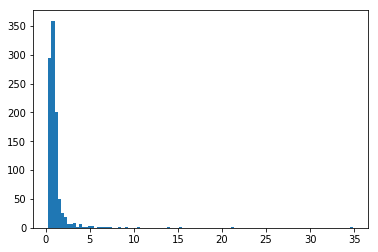

In [4]:
plt.hist(np.squeeze(np.array(A.sum(0)))[:1000], bins=100)
plt.show()

Looks like A is already normalized, and diagonal elements are nonzero. Maybe, we don't even need to calculate S? <br>
UPD. A is slightly worse then S: max accuracy 84.6 in comparison to 84.  

In [6]:
def get_s(A):
    D = np.diag(np.array(A.sum(0))[0])
    D = sqrtm(np.linalg.inv(D))
    return np.array(D@A@D)

# S = get_s(A)
S = np.array(A.todense())

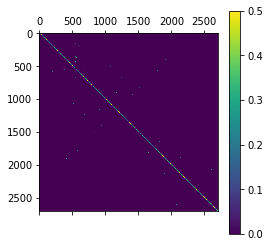

In [7]:
plt.matshow(S)
plt.colorbar()
plt.show()

In [8]:
k = 1000
Q, T = lanczos_algorithm(S, k)

100%|██████████| 1000/1000 [01:11<00:00, 10.30it/s]


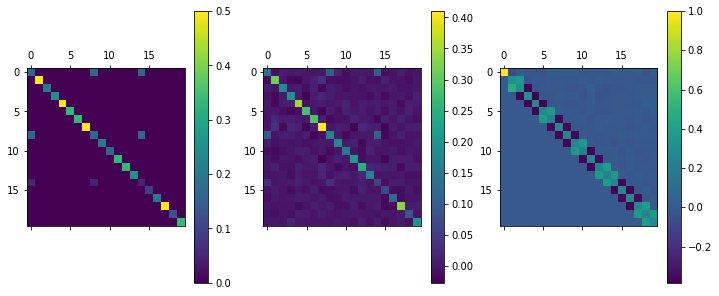

In [9]:
S_h=Q@T@Q.T
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
m1 = ax1.matshow(S[:20,:20])
m2 = ax2.matshow(S_h[:20,:20])
m3 = ax3.matshow(T[:20,:20])
f.colorbar(m1, ax=ax1)
f.colorbar(m2, ax=ax2)
f.colorbar(m3, ax=ax3)

In [10]:
from nn.layers import SpectralConv
from pygcn.pygcn.layers import GraphConvolution

In [11]:
from torch import nn

class LanczosConvNet(nn.Module):
    def __init__(self, k, feat_dim, num_classes, short_scales, long_scales):
        super(LanczosConvNet, self).__init__()
        self.spectral_conv = SpectralConv(k, short_scales, long_scales)
        inner_dim = (len(short_scales)+len(long_scales))*feat_dim
        
        self.conv1 = GraphConvolution(inner_dim, 512)
        self.conv2 = GraphConvolution(512, num_classes)
                                      
    def forward(self, adj, X, S, V, R):
        features = self.spectral_conv(X, S, V, R)
        Z = self.conv1(features, adj)
        Z = self.conv2(Z, adj)        
            
        return F.log_softmax(Z)
        

In [12]:
from scipy.linalg import eigh_tridiagonal

d = np.diagonal(T, 0)
e = np.diagonal(T, -1)
w, B = eigh_tridiagonal(d,e)

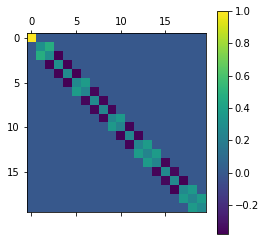

In [13]:
R = np.diag(w)
plt.matshow((B@R@B.T)[:20,:20]);
plt.colorbar()
plt.show()

In [14]:
n = adj.shape[0]
feat_dim = 1433
short_scales = [1,3,5]
long_scales = [10,20,30]
num_classes = 7
V = Q@B
model = LanczosConvNet(k, feat_dim,  num_classes, short_scales, long_scales)

In [15]:
import torch.nn.functional as F
import torch.optim as optim

from pygcn.pygcn.utils import accuracy

In [16]:
lr = 1e-2
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

A = torch.Tensor(A.todense()).cuda()
X = features.cuda()
S = torch.Tensor(S).cuda()
V = torch.Tensor(V).cuda()
w = torch.Tensor(w).cuda()
labels = labels.cuda()

In [17]:
loss_train_vals = []
loss_test_vals = []
acc_train_vals = []
acc_test_vals = []

def train(epoch, eval_epoch=3):
    model.train()
    optimizer.zero_grad()
    output = model(A, X, S, V, w)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    model.eval()
    output = model(A, X, S, V, w)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    
    loss_train_vals.append(loss_train.item())
    loss_test_vals.append(loss_val.item())
    acc_train_vals.append(acc_train.item())
    acc_test_vals.append(acc_val.item())
    
    if epoch > 0 and epoch%eval_epoch == 0:
        clear_output()
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.plot(loss_train_vals, label='train')
        ax1.plot(loss_test_vals, label='test')
        ax1.set_title('loss')
        ax1.legend()
        
        ax2.plot(acc_train_vals, label='train')
        ax2.plot(acc_test_vals, label='test')
        ax2.set_title('accuracy')
        ax2.legend()
        
        plt.show()
        
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train_vals[-1]),
              'acc_train: {:.4f}'.format(acc_train_vals[-1]),
              'loss_val: {:.4f}'.format(loss_test_vals[-1]),
              'acc_val: {:.4f}'.format(acc_test_vals[-1]))


def test():
    model.eval()
    output = model(A, X, S, V, w)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

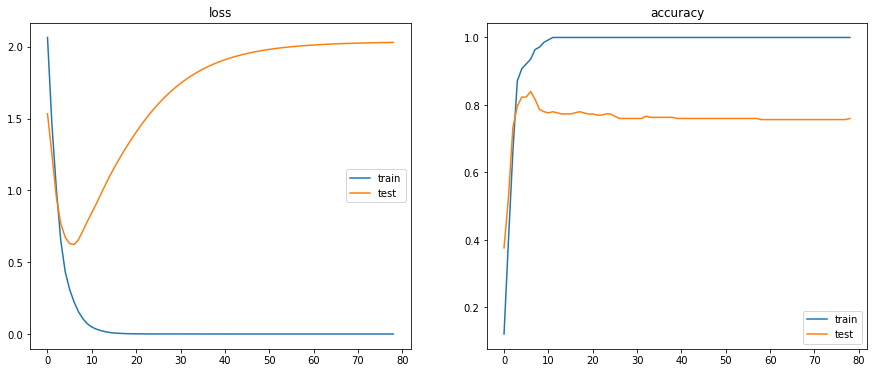

Epoch: 0079 loss_train: 0.0000 acc_train: 1.0000 loss_val: 2.0302 acc_val: 0.7600


min test loss: 	1.5335710048675537
max test accuracy: 	0.8400000000000001


In [18]:
epochs=80
for epoch in tqdm(range(epochs)):
    train(epoch)
print(f'\nmin test loss: \t{loss_test_vals[np.argmin(acc_test_vals)]}')
print(f'max test accuracy: \t{max(acc_test_vals)}')